# Segmenting and Clustering Neighborhoods in the city of  Toronto, Canada

#### In this assignment, you will be required to explore, segment, and cluster the neighborhoods in the city of Toronto. However, unlike New York, the neighborhood data is not readily available on the internet. What is interesting about the field of data science is that each project can be challenging in its unique way, so you need to learn to be agile and refine the skill to learn new libraries and tools quickly depending on the project.

### All the three parts are included in this notebook.

## Requirement 1: create a dataframe by web scraping wikipedia pages: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

In [3]:
!pip install folium

     |████████████████████████████████| 92kB 7.3MB/s eta 0:00:011


In [4]:
import requests
import bs4
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json 
from geopy.geocoders import Nominatim 
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [5]:
web_link = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

In [6]:
response = requests.get(web_link)

try:
    response.raise_for_status()
    soup_obj = bs4.BeautifulSoup(response.text, 'html.parser')
    
except Exception as exc:
    print('Error while downloading the webpage.. %s' % exc)

In [10]:
content = soup_obj.find('table', attrs={'class':'wikitable sortable'})
#content

#### create the data frame with columns: 'PostalCode', 'Borough', 'Neighborhood' and filtering those Boroughs which are not assigned

In [12]:
column_name = ['PostalCode', 'Borough', 'Neighborhood'] 
data_frame = pd.DataFrame(columns=column_name)
data_frame

for row in content.findAll('tr'):
    line_item = row.findAll('td')
    if (len(line_item) == 3):
        post_code = line_item[0].text.strip()
        borough = line_item[1].text.strip()
        neighborhood = line_item[2].text.strip()
        data_frame = data_frame.append({'PostalCode': post_code,
                                        'Borough': borough,
                                        'Neighborhood': neighborhood},
                                        ignore_index=True)
        
df = data_frame[data_frame['Borough'] != 'Not assigned']
df.head(12)

,PostalCode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor
7,M7A,Downtown Toronto,Queen's Park
9,M9A,Etobicoke,Islington Avenue
10,M1B,Scarborough,Rouge
11,M1B,Scarborough,Malvern
13,M3B,North York,Don Mills North


#### If it has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough. 

In [13]:
def set_neighborhood_as_borough(neighborhood):
    if neighborhood['Neighborhood'] == 'Not assigned':
        neighborhood['Neighborhood'] = neighborhood['Borough']
    return neighborhood
    
df = df.apply(set_neighborhood_as_borough, axis=1)
df.head(12)

,PostalCode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor
7,M7A,Downtown Toronto,Queen's Park
9,M9A,Etobicoke,Islington Avenue
10,M1B,Scarborough,Rouge
11,M1B,Scarborough,Malvern
13,M3B,North York,Don Mills North


#### More than one neighborhood can exist in one postal code area. Those rows will be combined into one row with the neighborhoods separated with a comma 

In [17]:
df = df.groupby(['PostalCode', 'Borough'], sort=False)['Neighborhood'].apply(', '.join).reset_index()
df.head(12)

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,"Lawrence Heights, Lawrence Manor"
4,M7A,Downtown Toronto,Queen's Park
5,M9A,Etobicoke,Islington Avenue
6,M1B,Scarborough,"Rouge, Malvern"
7,M3B,North York,Don Mills North
8,M4B,East York,"Woodbine Gardens, Parkview Hill"
9,M5B,Downtown Toronto,"Ryerson, Garden District"


In [18]:
df.shape

(103, 3)

## Requirement 2: get the latitude and the longitude coordinates of each neighborhood.

#### Reading the csv file and getting the coordinates of the postal codes

In [21]:
lat_lon_file = pd.read_csv('http://cocl.us/Geospatial_data')
lat_lon_file.columns = ['PostalCode', 'Latitude', 'Longitude']
lat_lon_file.head(n=10)

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
5,M1J,43.744734,-79.239476
6,M1K,43.727929,-79.262029
7,M1L,43.711112,-79.284577
8,M1M,43.716316,-79.239476
9,M1N,43.692657,-79.264848


#### Merging the dataframe with the neighborhood details dataframe created in Question 1 to create the final dataframe

In [24]:
df_toronto = pd.merge(df, lat_lon_file, on='PostalCode')
df_toronto.head(12)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
4,M7A,Downtown Toronto,Queen's Park,43.662301,-79.389494
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242
6,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
7,M3B,North York,Don Mills North,43.745906,-79.352188
8,M4B,East York,"Woodbine Gardens, Parkview Hill",43.706397,-79.309937
9,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937


## Requirement 3: Replicate NYC analysis and generate map for neighborhoods and clusters in Toronto. 

Boroughs only containing Toronto

In [25]:
toronto_borough = df_toronto[df_toronto['Borough'].str.contains('Toronto')].reset_index(drop=True)
toronto_borough.head(12)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
1,M7A,Downtown Toronto,Queen's Park,43.662301,-79.389494
2,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031
5,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306
6,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
7,M6G,Downtown Toronto,Christie,43.669542,-79.422564
8,M5H,Downtown Toronto,"Adelaide, King, Richmond",43.650571,-79.384568
9,M6H,West Toronto,"Dovercourt Village, Dufferin",43.669005,-79.442259


In [27]:
print('{} Postal codes with Toronto'.format(toronto_borough.shape[0]))

39 Postal codes with Toronto


### Explore the neighborhoods in Toronto using Foursquare

In [28]:
CLIENT_ID = 'OB4DHAYWNJTHCJJ4K5OHRUKWI1LMAHIM0BDG3CLEZKMFCZJB' # Foursquare ID
CLIENT_SECRET = 'LVLRJSVSGMNZZG3GC1VLDSKAB4VFWO2HNTO1ZW43T33T0IKE' # Foursquare Secret
VERSION = '20200301' # Foursquare API version

In [29]:
radius = 500
limit = 100

In [30]:
def getNearbyVenuesbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # API URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # get results
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [31]:
toronto_venues = getNearbyVenuesbyVenues(names=toronto_borough['Neighborhood'],latitudes=toronto_borough['Latitude'],longitudes=toronto_borough['Longitude']                            )

In [32]:
print(toronto_venues.shape)
toronto_venues.head(12)

(1715, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Harbourfront,43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,Harbourfront,43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,Harbourfront,43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,Harbourfront,43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,Harbourfront,43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot
5,Harbourfront,43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant
6,Harbourfront,43.65426,-79.360636,Corktown Common,43.655618,-79.356211,Park
7,Harbourfront,43.65426,-79.360636,Figs Breakfast & Lunch,43.655675,-79.364503,Breakfast Spot
8,Harbourfront,43.65426,-79.360636,The Distillery Historic District,43.650244,-79.359323,Historic Site
9,Harbourfront,43.65426,-79.360636,Dominion Pub and Kitchen,43.656919,-79.358967,Pub


In [35]:
toronto_venues[['Neighborhood','Venue']].groupby('Neighborhood').count()

,Venue
Neighborhood,
"Adelaide, King, Richmond",100
Berczy Park,56
"Brockton, Exhibition Place, Parkdale Village",23
Business Reply Mail Processing Centre 969 Eastern,16
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",17
"Cabbagetown, St. James Town",45
Central Bay Street,80
"Chinatown, Grange Park, Kensington Market",89
Christie,18


In [40]:
neighborhood_venue_category = toronto_venues[['Neighborhood','Venue Category','Venue']].groupby(['Neighborhood','Venue Category']).count()
top_neighborhood_venue_category = neighborhood_venue_category[neighborhood_venue_category['Venue'] > 4]
top_neighborhood_venue_category                                                              

Venue
Neighborhood                                      Venue Category              
Adelaide, King, Richmond                          Coffee Shop                7
                                                  Restaurant                 5
Berczy Park                                       Coffee Shop                5
Central Bay Street                                Coffee Shop               13
Chinatown, Grange Park, Kensington Market         Bar                        6
                                                  Café                       5
                                                  Vietnamese Restaurant      5
Church and Wellesley                              Coffee Shop                7
                                                  Japanese Restaurant        6
Commerce Court, Victoria Hotel                    Café                       7
                                                  Coffee Shop               10
                                                  Hotel                      6
                                                  Restaurant                 7
Design Exchange, Toronto Dominion Centre          Café                       8
                                                  Coffee Shop               13
                                                  Hotel                      5
                                                  Restaurant                 6
First Canadian Place, Underground city            Café                       7
                                                  Coffee Shop               12
                                                  Restaurant                 6
Harbord, University of Toronto                    Café                       5
Harbourfront                                      Coffee Shop                7
Harbourfront East, Toronto Islands, Union Station Aquarium                   5
                                                  Coffee Shop               12
Little Portugal, Trinity                          Bar                        7
Queen's Park                                      Coffee Shop                9
Ryerson, Garden District                          Clothing Store             8
                                                  Coffee Shop               10
St. James Town                                    Café                       6
                                                  Coffee Shop                7
                                                  Restaurant                 5
Stn A PO Boxes 25 The Esplanade                   Coffee Shop               11
The Danforth West, Riverdale                      Greek Restaurant           8

### Analyze neighborhoods

In [41]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
toronto_onehot = toronto_onehot.rename(columns={"Neighborhood": "Neighborhod"})
toronto_onehot.insert(0, 'Neighborhood', toronto_venues['Neighborhood'])
# group by neighborhood
toronto_grouped = toronto_onehot.groupby("Neighborhood").mean().reset_index()

### Clustering the neighborhoods

In [42]:
# cluster #
n = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# kmeans clustering
kmeans = KMeans(n_clusters=n, random_state=0).fit(toronto_grouped_clustering)
kmeans.labels_[:12] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [44]:
neighbors = toronto_borough[['Neighborhood','Latitude','Longitude']]
neighbors.head()

,Neighborhood,Latitude,Longitude
0,Harbourfront,43.654260,-79.360636
1,Queen's Park,43.662301,-79.389494
2,"Ryerson, Garden District",43.657162,-79.378937
3,St. James Town,43.651494,-79.375418
4,The Beaches,43.676357,-79.293031


In [51]:
neighborhoods = toronto_grouped[['Neighborhood']]
neighborhoods.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods.head()

,Cluster Labels,Neighborhood
0,0,"Adelaide, King, Richmond"
1,0,Berczy Park
2,0,"Brockton, Exhibition Place, Parkdale Village"
3,0,Business Reply Mail Processing Centre 969 Eastern
4,0,"CN Tower, Bathurst Quay, Island airport, Harbo..."


In [54]:
locations = toronto_borough[['Neighborhood','Latitude','Longitude']]
locations = locations.join(neighborhoods.set_index('Neighborhood'),on='Neighborhood')
locations.head()

,Neighborhood,Latitude,Longitude,Cluster Labels
0,Harbourfront,43.654260,-79.360636,0
1,Queen's Park,43.662301,-79.389494,0
2,"Ryerson, Garden District",43.657162,-79.378937,0
3,St. James Town,43.651494,-79.375418,0
4,The Beaches,43.676357,-79.293031,4


### generate the map

In [55]:
# get location of Toronto
address = 'Toronto, CA'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [58]:
# generate map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(n)
ys = [i + x + (i*x)**2 for i in range(n)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(locations['Latitude'], locations['Longitude'], locations['Neighborhood'], locations['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
        
map_clusters

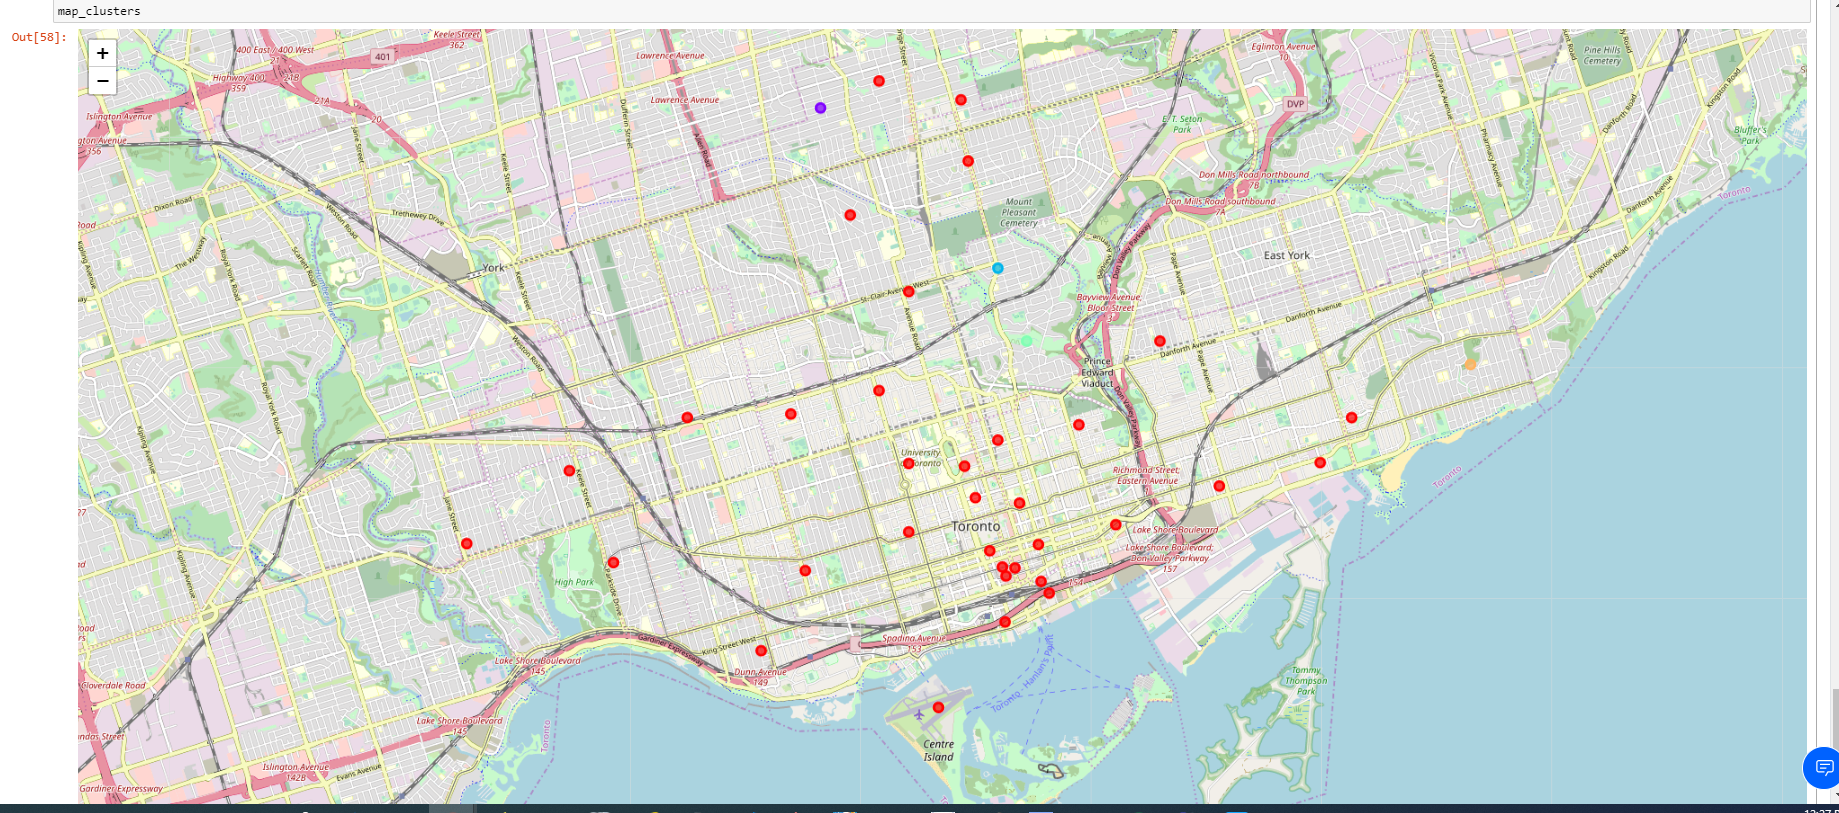